In [20]:
import datetime
import json
from pathlib import Path

import imageio.v2 as imageio
import numpy as np
import pandas as pd
import rasterio
import torch
import tqdm
import yaml
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import balanced_accuracy_score
from torch.utils.data import DataLoader

from estuary.clay.data import EstuaryDataModule, EstuaryDataset, load_labels, parse_dt_from_pth
from estuary.clay.module import EstuaryModule
from estuary.util import masked_contrast_stretch

In [2]:
BASE = Path("/Users/kyledorman/data/results/estuary/train/20250828-144342/")
CKPT = BASE / "checkpoints" / "last.ckpt"
LABEL_PATH = Path("/Users/kyledorman/data/estuary/label_studio/00025/labels.csv")
CROP_PATH = Path("/Users/kyledorman/data/estuary/label_studio/region_crops.json")
region_crops = json.loads(CROP_PATH.read_bytes())

In [148]:
module = EstuaryModule.load_from_checkpoint(CKPT, batch_size=1, strict=False)
module = module.eval()
dm = EstuaryDataModule(module.conf)
dm.prepare_data()
dm.setup()


def calc_confs(dl):
    labels = []
    confs = []
    for batch, blabel in tqdm.tqdm(dl, total=len(dl)):
        for k in batch.keys():
            batch[k] = batch[k].to(module.device)
        pred_batch = module.forward(batch)
        confs.extend(torch.sigmoid(pred_batch)[0].detach().cpu().numpy().tolist())
        labels.extend(blabel.detach().cpu().numpy().tolist())

    return pd.DataFrame(
        list(zip(labels, confs, dm.test_ds.df.region.tolist(), strict=False)),
        columns=["label", "conf", "region"],
    )


def best_thresholds_by_region(df: pd.DataFrame, n_steps: int = 25):
    """
    Given dataframe with 'label', 'conf', 'region' columns:
    - label: ground truth {0,1}
    - conf: model confidence/probability for class 1
    - region: region identifier

    Returns a DataFrame with region, best_threshold, best_bal_acc.
    """
    regions = df["region"].unique()
    results = []
    thresholds = np.linspace(0, 1, n_steps)

    for region in regions:
        sub = df[df["region"] == region]
        y_true = sub["label"].to_numpy()
        y_conf = sub["conf"].to_numpy()

        best_score, best_thr = -1, None
        for thr in thresholds:
            y_pred = (y_conf >= thr).astype(int)
            score = balanced_accuracy_score(y_true, y_pred)
            if score > best_score:
                best_score, best_thr = score, thr

        results.append({"region": region, "best_threshold": best_thr, "best_bal_acc": best_score})

    return pd.DataFrame(results)


train_df = calc_confs(dm.train_dataloader())

Some label classes will be ignored {'unsure'}
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2353/2353 [06:51<00:00,  5.71it/s]


In [149]:
train_df.groupby("region").label.max() - train_df.groupby("region").label.min()

region
big_sur_river             1
carmel                    1
goleta                    1
little_sur                1
los_penasquitos_lagoon    1
malibu_lagoon             1
navarro_river             1
pismo_creek_lagoon        1
russian_river             1
san_dieguito_lagoon       1
san_elijo_lagoon          1
san_mateo_lagoon          1
santa_margarita           1
topanga                   1
ventura                   1
Name: label, dtype: int64

In [161]:
thresholds = best_thresholds_by_region(train_df, 21)

thresholds.to_csv(BASE / "thresholds.csv")

thresholds.head(15).round(2)

,region,best_threshold,best_bal_acc
0,pismo_creek_lagoon,0.25,1.00
1,carmel,0.30,0.97
2,ventura,0.40,1.00
3,los_penasquitos_lagoon,0.35,1.00
4,san_mateo_lagoon,0.15,0.92
5,san_elijo_lagoon,0.35,1.00
6,malibu_lagoon,0.25,1.00
7,topanga,0.35,1.00
8,russian_river,0.15,1.00
9,san_dieguito_lagoon,0.30,1.00


In [151]:
test_df = calc_confs(dm.test_dataloader())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:42<00:00,  6.73it/s]


In [160]:
test_df["pred"] = 0
for _, row in thresholds.iterrows():
    k = test_df.region == row.region
    test_df.loc[k, "pred"] = (test_df[k].conf >= row.best_threshold).astype(int)

# Compute balanced accuracy per region
test_region_balanced_acc = (
    test_df.groupby("region")
    .apply(lambda df: balanced_accuracy_score(df["label"], df["pred"]))
    .reset_index(name="balanced_accuracy")
).set_index("region")

test_acc = balanced_accuracy_score(test_df.label, test_df.pred)

print(round(100 * test_acc, 1))

test_region_balanced_acc.head(3).round(3)

82.0


/Users/kyledorman/Documents/UCLA_kelp/estuary/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/var/folders/pr/1dt1qk511zdgzhfy1xskpqm00000gn/T/ipykernel_95289/3775653935.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: balanced_accuracy_score(df["label"], df["pred"]))


,balanced_accuracy
region,
big_sur_river,0.455
carmel,0.864
goleta,0.819


In [3]:
def draw_label(
    img: Image.Image, text: str, color: tuple[int, int, int], add_border=True
) -> Image.Image:
    """Draw a semi-transparent banner with outlined text, and optional colored border."""
    # Optional: try a nicer font; fall back to default if not available
    try:
        FONT = ImageFont.truetype("/System/Library/Fonts/Supplemental/Arial Bold.ttf", 20)
    except Exception:
        FONT = ImageFont.load_default()

    draw = ImageDraw.Draw(img, "RGBA")
    w, h = img.size

    # Banner box
    pad_x, pad_y = 10, 8
    text_w, text_h = draw.textbbox((0, 0), text, font=FONT)[2:]
    box_w = min(w - 2 * pad_x, text_w + 2 * pad_x)
    box_h = text_h + 2 * pad_y

    # Top-left anchor for banner
    x0, y0 = pad_x, pad_y
    x1, y1 = x0 + box_w, y0 + box_h

    # Semi-transparent dark banner
    draw.rounded_rectangle([x0, y0, x1, y1], radius=10, fill=(0, 0, 0, 110))

    # Outlined text (stroke) for readability
    draw.text(
        (x0 + pad_x, y0 + pad_y),
        text,
        font=FONT,
        fill=(255, 255, 255, 255),
        stroke_width=2,
        stroke_fill=(0, 0, 0, 220),
    )

    # Optional border matching class color
    if add_border:
        draw.rectangle([0, 0, w - 1, h - 1], outline=color + (255,), width=4)

    return img

In [57]:
valid_df = pd.read_csv(BASE / "valid.csv")
valid_df["acquired"] = pd.to_datetime(valid_df["acquired"], errors="coerce")
valid_df["acquired_date"] = valid_df.acquired.dt.date
valid_df.head(3)

,region,udm_path,source_tif,label_idx,pred,conf,acquired,acquired_date
0,big_sur_river,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/dove/results/20...,0,0,0.0,2019-01-01 18:25:38,2019-01-01
1,big_sur_river,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/dove/results/20...,0,0,0.0,2019-01-03 17:54:52,2019-01-03
2,big_sur_river,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/dove/results/20...,0,0,0.0,2019-01-04 17:54:40,2019-01-04


In [58]:
counts = valid_df.groupby("region")["acquired_date"].nunique()
counts.head(15)

region
big_sur_river             672
carmel                    548
goleta                    751
little_sur                573
los_penasquitos_lagoon    654
malibu_lagoon             741
navarro_river             605
pismo_creek_lagoon        742
russian_river             690
san_dieguito_lagoon       696
san_elijo_lagoon          688
san_mateo_lagoon          733
santa_margarita           673
topanga                   809
ventura                   712
Name: acquired_date, dtype: int64

In [162]:
preds = pd.read_csv(BASE / "preds.csv")
preds["acquired"] = pd.to_datetime(preds["acquired"], errors="coerce")
preds["acquired_date"] = preds.acquired.dt.date
preds["pred"] = 0
for _, row in thresholds.iterrows():
    k = preds.region == row.region
    preds.loc[k, "pred"] = (preds[k].conf >= row.best_threshold).astype(int)

preds.head(3)

,region,udm_path,source_tif,label_idx,pred,conf,acquired,acquired_date
0,big_sur_river,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/dove/results/20...,0,0,0.005740,2019-01-01 18:25:38,2019-01-01
1,big_sur_river,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/dove/results/20...,0,0,0.003372,2019-01-03 17:54:52,2019-01-03
2,big_sur_river,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/dove/results/20...,0,0,0.028122,2019-01-04 17:54:40,2019-01-04


In [123]:
labels = pd.read_csv(LABEL_PATH)
labels["acquired"] = labels.source_tif.apply(lambda a: parse_dt_from_pth(Path(a)))
labels["acquired"] = pd.to_datetime(labels["acquired"], errors="coerce")
labels["acquired_date"] = labels.acquired.dt.date
labels = labels[labels.label != "unsure"]
labels = labels.sort_values(by=["region", "acquired"]).reset_index(drop=True)

labels.head(3)

,region,source_tif,source_jpeg,label,acquired,acquired_date
0,big_sur_river,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open,2019-01-19 18:26:39,2019-01-19
1,big_sur_river,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open,2019-01-24 18:28:06,2019-01-24
2,big_sur_river,/Users/kyledorman/data/estuary/dove/results/20...,/Users/kyledorman/data/estuary/label_studio/00...,open,2019-02-23 18:29:41,2019-02-23


In [124]:
counts = labels.groupby("region")["acquired"].nunique()
counts.head(15)

region
big_sur_river             194
carmel                    199
goleta                    199
little_sur                197
los_penasquitos_lagoon    192
malibu_lagoon             196
navarro_river             198
pismo_creek_lagoon        193
russian_river             195
san_dieguito_lagoon       200
san_elijo_lagoon          199
san_mateo_lagoon          197
santa_margarita           198
topanga                   197
ventura                   195
Name: acquired, dtype: int64

In [163]:
# assume df has columns: region, acquired (datetime), label_idx {0=open, 1=closed}
labels["year"] = pd.to_datetime(labels["acquired"]).dt.year
labels["label_idx"] = (labels.label == "closed").astype(int)

# group by region/year
stats = (
    labels[labels.region.isin(["ventura", "topanga", "goleta", "malibu_lagoon"])]
    .groupby(["region", "year"])
    .agg(total=("label_idx", "size"), open_count=("label_idx", lambda x: (x == 0).sum()))
    .assign(pct_open=lambda d: 100 * d["open_count"] / d["total"])
    .reset_index()
)

# assume df has columns: region, acquired (datetime), label_idx {0=open, 1=closed}
preds["year"] = pd.to_datetime(preds["acquired"]).dt.year

# group by region/year
stats_p = (
    preds[preds.region.isin(["ventura", "topanga", "goleta", "malibu_lagoon"])]
    .groupby(["region", "year"])
    .agg(total=("label_idx", "size"), open_count=("pred", lambda x: (x == 0).sum()))
    .assign(pct_open=lambda d: 100 * d["open_count"] / d["total"])
    .reset_index()
)
print(stats_p.head())

print(stats.head())

   region  year  total  open_count   pct_open
0  goleta  2019    160         152  95.000000
1  goleta  2020    190         165  86.842105
2  goleta  2021    232         164  70.689655
3  goleta  2022    223         181  81.165919
4  goleta  2023    139          95  68.345324
   region  year  total  open_count   pct_open
0  goleta  2019     31          28  90.322581
1  goleta  2020     36          29  80.555556
2  goleta  2021     46          27  58.695652
3  goleta  2022     45          40  88.888889
4  goleta  2023     28          22  78.571429


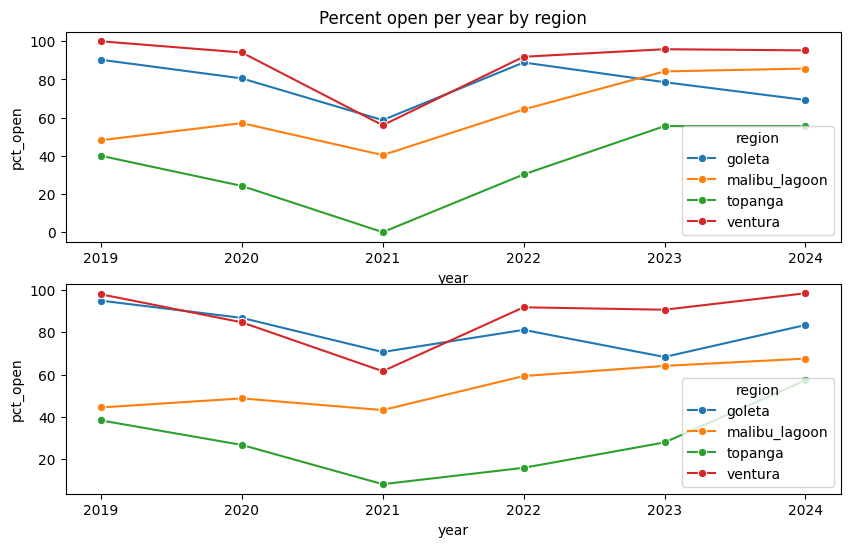

In [164]:
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(10, 6))
sns.lineplot(data=stats, x="year", y="pct_open", hue="region", marker="o", ax=axes[0])
axes[0].set_title("Percent open per year by region")
sns.lineplot(data=stats_p, x="year", y="pct_open", hue="region", marker="o", ax=axes[1])
plt.show()

In [127]:
high_res = []
for pth in Path("/Users/kyledorman/data/estuary/skysat/results/").glob(
    "*/*/files/*_pansharpened_clip.tif"
):
    yearmonthday = pth.stem.split("_")[0]
    dt = pd.to_datetime(yearmonthday, format="%Y%m%d")
    high_res.append([pth, pth.parent.parent.name, dt])
high_res_df = pd.DataFrame(high_res, columns=["path", "region", "acquired"])
high_res_df = high_res_df.sort_values(by=["region", "acquired"]).reset_index(drop=True)

high_res_df.head(3)

,path,region,acquired
0,/Users/kyledorman/data/estuary/skysat/results/...,big_sur_river,2019-09-06
1,/Users/kyledorman/data/estuary/skysat/results/...,big_sur_river,2021-02-21
2,/Users/kyledorman/data/estuary/skysat/results/...,big_sur_river,2022-11-12


In [128]:
counts = high_res_df.groupby("region")["acquired"].nunique()
counts.head(15)

region
big_sur_river              4
carmel                     1
goleta                    92
little_sur                 2
los_penasquitos_lagoon     8
malibu_lagoon              2
navarro_river             11
pismo_creek_lagoon         7
russian_river              4
san_dieguito_lagoon       10
san_elijo_lagoon           6
san_mateo_lagoon           8
santa_margarita            6
topanga                   12
ventura                   12
Name: acquired, dtype: int64

In [45]:
holdout_acc = []
runs = []
for pth in Path("/Users/kyledorman/data/results/estuary/train/").glob("202*"):
    if not pth.is_dir():
        continue
    with open(pth / "cli_diff.yaml") as f:
        config = yaml.safe_load(f)
    if "holdout_region" not in config:
        continue
    runs.append(pth)

print(f"Found {len(runs)} holdout regions")

for pth in runs:
    with open(pth / "cli_diff.yaml") as f:
        config = yaml.safe_load(f)
    ckpt = next((pth / "checkpoints").glob("epoch*"))
    module = EstuaryModule.load_from_checkpoint(ckpt, batch_size=1, strict=False)
    module = module.eval()
    holdout_region = module.conf.holdout_region
    run_labels = load_labels(module.conf)

    ds = EstuaryDataset(
        run_labels[run_labels.region == holdout_region], crops_map=region_crops, conf=module.conf
    )
    dl = DataLoader(ds, batch_size=1)
    rpreds = []
    rlabels = []
    for batch, blabel in tqdm.tqdm(dl, total=len(dl)):
        for k in batch.keys():
            batch[k] = batch[k].to(module.device)
        pred_batch = module.forward(batch)
        bpred = (torch.sigmoid(pred_batch) > 0.15).to(torch.int32).detach().cpu().numpy()
        rpreds.extend(bpred[0].tolist())
        rlabels.extend(blabel.detach().cpu().numpy().tolist())

    holdout_acc.append((holdout_region, balanced_accuracy_score(rlabels, rpreds)))

holdout_acc = pd.DataFrame(holdout_acc, columns=["region", "holdout_acc"]).set_index("region")

Found 2 holdout regions


Some label classes will be ignored {'unsure'}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [01:14<00:00,  2.66it/s]
Some label classes will be ignored {'unsure'}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [01:05<00:00,  2.96it/s]


In [208]:
labels.groupby("region").label_idx.mean().round(2)

region
big_sur_river             0.12
carmel                    0.68
goleta                    0.22
little_sur                0.24
los_penasquitos_lagoon    0.15
malibu_lagoon             0.41
navarro_river             0.56
pismo_creek_lagoon        0.34
russian_river             0.13
san_dieguito_lagoon       0.00
san_elijo_lagoon          0.08
san_mateo_lagoon          0.86
santa_margarita           0.04
topanga                   0.72
ventura                   0.15
Name: label_idx, dtype: float64

In [165]:
data_stats = pd.concat(
    [
        valid_df.groupby("region")["acquired_date"].nunique().rename("dove_total"),
        labels.groupby("region").acquired.nunique().rename("dove_labeled"),
        high_res_df.groupby("region").acquired.nunique().rename("skysat_total"),
        test_region_balanced_acc.balanced_accuracy.rename("test_accuracy").round(2),
        # holdout_acc.round(2),
    ],
    axis=1,
)

data_stats.to_csv("/Users/kyledorman/data/estuary/display/region_stats.csv")
data_stats.head(15)

,dove_total,dove_labeled,skysat_total,test_accuracy
region,,,,
big_sur_river,672,194,4,0.45
carmel,548,199,1,0.86
goleta,751,199,92,0.82
little_sur,573,197,2,0.83
los_penasquitos_lagoon,654,192,8,0.50
malibu_lagoon,741,196,2,0.92
navarro_river,605,198,11,0.87
pismo_creek_lagoon,742,193,7,0.89
russian_river,690,195,4,0.50


In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(5 * 2.9, 3 * 3), constrained_layout=True)
for (region, rows), ax in zip(preds.groupby("region"), axes.flatten(), strict=False):
    ax.axis("off")
    ax.set_title(" ".join([r.capitalize() for r in region.split("_")]))
    crop = region_crops[region]
    start_w, start_h, end_w, end_h = crop
    w = end_w - start_w
    h = end_h - start_h
    pth = rows.iloc[6].source_tif
    with rasterio.open(pth) as src:
        data = src.read(out_dtype=np.float32)[:, start_h:end_h, start_w:end_w]
        nodata = src.read(1, masked=True).mask[start_h:end_h, start_w:end_w]
    data = np.log10(data + 1)
    imgd = masked_contrast_stretch(data, ~nodata, p_low=1, p_high=99)
    rgb = imgd[[2, 1, 0]].transpose((1, 2, 0))
    img = Image.fromarray(np.array(np.clip(rgb * 255, 0, 255), dtype=np.uint8)).resize((256, 256))
    ax.imshow(img)

plt.savefig("/Users/kyledorman/data/estuary/display/all_sites_dove.png")
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(5 * 2.9, 3 * 3), constrained_layout=True)
for (region, rows), ax in zip(high_res_df.groupby("region"), axes.flatten(), strict=False):
    ax.axis("off")
    ax.set_title(" ".join([r.capitalize() for r in region.split("_")]))
    pth = rows.iloc[0].path
    with rasterio.open(pth) as src:
        data = src.read([3, 2, 1], out_dtype=np.float32)
        nodata = src.read(1, masked=True).mask
    data = np.log10(data + 1)
    imgd = masked_contrast_stretch(data, ~nodata, p_low=1, p_high=99)
    rgb = imgd.transpose((1, 2, 0))
    img = Image.fromarray(np.array(np.clip(rgb * 255, 0, 255), dtype=np.uint8)).resize((512, 512))
    ax.imshow(img)

plt.savefig("/Users/kyledorman/data/estuary/display/all_sites_skysat.png")
plt.show()

In [202]:
region = "malibu_lagoon"
start = datetime.datetime(year=2024, month=9, day=1)
end = datetime.datetime(year=2024, month=12, day=31)
crop = region_crops[region]
start_w, start_h, end_w, end_h = crop
w = end_w - start_w
h = end_h - start_h

ddf = preds
gif_df = ddf[(ddf.region == region) & (ddf.acquired > start) & (ddf.acquired < end)]

len(gif_df)

32

In [203]:
save_path = Path(f"/Users/kyledorman/data/estuary/display/gifs/{region}_{start.date()}.mp4")
save_path.parent.mkdir(exist_ok=True, parents=True)

frames = []
for _, row in tqdm.tqdm(gif_df.iterrows(), total=len(gif_df)):
    pth = row.source_tif
    pred_name = "open" if row.pred == 0 else "close"
    pred_color = (44, 160, 44) if row.pred == 0 else (214, 39, 40)  # green/red
    conf_str = f"{row.conf:.2f}" if "conf" in gif_df.columns else "—"
    date_str = getattr(row, "acquired", None)
    if date_str is not None:
        # Parse YYYYMMDD or ISO-like strings robustly
        try:
            # if already datetime-like, this is a no-op; else try %Y%m%d
            dt = pd.to_datetime(date_str, format="%Y%m%d", errors="ignore")
            dt = pd.to_datetime(dt)  # ensure Timestamp
            date_disp = dt.strftime("%Y-%m-%d")
        except Exception:
            date_disp = str(date_str)
    else:
        date_disp = ""

    with rasterio.open(pth) as src:
        data = src.read(out_dtype=np.float32)[:, start_h:end_h, start_w:end_w]
        nodata = src.read(1, masked=True).mask[start_h:end_h, start_w:end_w]
    data = np.log10(data + 1)
    imgd = masked_contrast_stretch(data, ~nodata, p_low=1, p_high=99)
    rgb = imgd[[2, 1, 0]].transpose((1, 2, 0))
    img = Image.fromarray(np.array(np.clip(rgb * 255, 0, 255), dtype=np.uint8)).resize((256, 256))

    # Compose label text — include region/pred/conf/date as you like
    label_text = f"{pred_name}"
    if date_disp:
        label_text = f"{date_disp} • " + label_text

    img = draw_label(img, label_text, pred_color, add_border=True)

    frames.append(img)

# Convert each PIL frame to a NumPy array (imageio needs ndarray or PIL)
frame_arrays = [np.array(im.convert("RGB")) for im in frames]

  0%|                                                                                                                                                                                                       | 0/32 [00:00<?, ?it/s]/var/folders/pr/1dt1qk511zdgzhfy1xskpqm00000gn/T/ipykernel_95289/1849934157.py:15: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  dt = pd.to_datetime(date_str, format="%Y%m%d", errors="ignore")
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 50.37it/s]


In [204]:
# Write MP4 (H.264)
fps = 1
imageio.mimsave(
    save_path,
    frame_arrays,
    fps=fps,
    codec="libx264",  # H.264 for compatibility
    quality=10,  # 0 (lowest) - 10 (highest) for libx264
    macro_block_size=None,  # keeps original frame size
)
print(f"Saved video → {save_path}")

Saved video → /Users/kyledorman/data/estuary/display/gifs/malibu_lagoon_2024-09-01.mp4


In [189]:
from IPython.display import Video

Video(str(save_path), embed=True, width=600)

In [190]:
save_base = Path("/Users/kyledorman/data/estuary/display/skysat")
ddf = valid_df
for region in ddf.region.unique():
    pdf = ddf[ddf.region == region]
    hdf = high_res_df[high_res_df.region == region]
    # Work on sorted copies (required by merge_asof)
    hdf_s = hdf.sort_values("acquired").reset_index(drop=True)
    pdf_s = pdf.sort_values("acquired").reset_index(drop=True)
    # Nearest match within n days
    pairs = pd.merge_asof(
        hdf_s,
        pdf_s,
        on="acquired",
        direction="nearest",
        tolerance=pd.Timedelta("2D"),
        suffixes=("_h", "_p"),
    )
    # Keep only rows that found a match (otherwise columns from pdf will be NaN)
    pairs = pairs.dropna(subset=["path", "source_tif"])

    save = save_base / region
    save.mkdir(exist_ok=True, parents=True)

    crop = region_crops[region]
    start_w, start_h, end_w, end_h = crop
    w = end_w - start_w
    h = end_h - start_h

    for state in [0, 1]:
        for _, row in pairs[pairs.pred == state].iterrows():
            with rasterio.open(row.path) as src:
                data = src.read(out_dtype=np.float32)
                nodata = src.read(1, masked=True).mask
            data = np.log10(data + 1)
            imgd = masked_contrast_stretch(data, ~nodata, p_low=1, p_high=99)
            rgb = imgd[[2, 1, 0]].transpose((1, 2, 0))
            sky_img = Image.fromarray(np.array(np.clip(rgb * 255, 0, 255), dtype=np.uint8)).resize(
                (512, 512)
            )

            pred_name = "open" if row.pred == 0 else "close"

            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            axes[0].imshow(sky_img)
            axes[0].axis("off")

            with rasterio.open(row.source_tif) as src:
                data = src.read(out_dtype=np.float32)[:, start_h:end_h, start_w:end_w]
                nodata = src.read(1, masked=True).mask[start_h:end_h, start_w:end_w]
            data = np.log10(data + 1)
            imgd = masked_contrast_stretch(data, ~nodata, p_low=1, p_high=99)
            rgb = imgd[[2, 1, 0]].transpose((1, 2, 0))
            img = Image.fromarray(np.array(np.clip(rgb * 255, 0, 255), dtype=np.uint8)).resize(
                (256, 256)
            )

            axes[1].imshow(img)
            axes[1].axis("off")

            fig.suptitle(f"Prediction: {pred_name}   Date: {row.acquired.date()}")

            plt.tight_layout()
            # plt.show()
            plt.savefig(save / f"{pred_name}_{row.acquired.date()}.png")
            plt.close()